<a href="https://colab.research.google.com/github/SCCSMARTCODE/Deep-Learning-00/blob/main/Deep-Learning-00/Cifar_10_cnn_version1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch.nn import functional as F
from torch import nn
from torch.optim import Adam
from torchvision.datasets import CIFAR10
import torchvision.transforms as tt
from torch.utils.data import random_split, DataLoader
from torch.optim.lr_scheduler import OneCycleLR
from pprint import pprint

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"{device.type} is available")

cuda is available


In [3]:
class Cifar10CNN(nn.Module):

    def __init__(self):
        super(Cifar10CNN, self).__init__()

        self.conv_layers = nn.Sequential(
            # Input: 3 * 32 * 32
            nn.Conv2d(3, 16, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),

            nn.Conv2d(16, 32, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(32),
            # Output: 32 * 16 * 16

            nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),

            nn.Conv2d(64,128, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(128),
            # Output: 128 * 8 * 8

            nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),

            nn.Conv2d(256, 512, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(512)
            # Output: 512 * 4 * 4
        )

        self.full_connected = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(64, 10),
        )

    def forward(self, input):
        return self.full_connected(self.conv_layers(input))

# Model instantiation and device transfer
model = Cifar10CNN()
model.to(device=device)


Cifar10CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [4]:
dataset_path="/content/drive/MyDrive/Deep Learning/cifar_10"


transformation = tt.Compose([
    tt.ToTensor(),
    tt.Pad(3, padding_mode="reflect"),
    tt.RandomCrop(size=32),
    tt.RandomRotation(10),
    tt.RandomHorizontalFlip()
])


train_dataset = CIFAR10(root=dataset_path, transform=transformation, train=True)
test_dataset = CIFAR10(root=dataset_path, transform=transformation, train=False)

In [17]:
WEIGHT_DECAY=1e-4
MAX_LR=1e-4
EPOCHS=10




train_inputs, val_inputs = random_split(train_dataset, [45000, 5000])
train_dl = DataLoader(train_inputs, batch_size=512, shuffle=True, pin_memory=True, num_workers=2)
val_dl = DataLoader(val_inputs, batch_size=128)
loss_fn = F.cross_entropy
optim = Adam(model.parameters(), lr=0.00081, weight_decay=WEIGHT_DECAY)
lr_scheduler = OneCycleLR(optim, max_lr=MAX_LR, total_steps=EPOCHS*len(train_dl))

In [6]:
@torch.no_grad
def accuracy(val_dl):
    acc_count = 0
    data_points = 0
    for input, label in val_dl:
        input = input.to(device=device)
        label = label.to(device=device)
        _, index = torch.max(model(input), dim=1)
        acc_count += sum([1 for x, y in zip(index, label) if x == y])
        data_points += len(label)

    return acc_count/data_points


@torch.no_grad
def evaluate(val_dl):
    model.eval()
    losses = []
    for input, label in val_dl:
        input = input.to(device=device)
        label = label.to(device=device)
        output = model(input)
        loss = nn.CrossEntropyLoss()(output, label)
        losses.append(loss.item())

    loss = torch.mean(torch.tensor(losses))

    acc = accuracy(val_dl)
    return {"val_loss": loss, "val_acc": acc}


In [8]:
def train(epochs, model, train_dl, loss_fn, optim, val_dl, lr_scheduler):
    val_history = []
    training_loss_history = []
    for epoch in range(epochs):
        model.train()

        for inputs, labels in train_dl:
            batch_loss = []
            inputs = inputs.to(device=device)
            labels = labels.to(device=device)

            pred = model(inputs)
            loss = loss_fn(pred, labels)
            batch_loss.append(loss)
            loss.backward()
            optim.step()
            lr_scheduler.step()

            optim.zero_grad()

            # grad = model.named_parameters()
            # return grad


        loss_mean = torch.mean(torch.stack(batch_loss))
        training_loss_history.append(loss_mean)

        # validation stage
        validation_update = evaluate(val_dl)
        val_history.append(validation_update)
        torch.save(model.state_dict(), "/content/drive/MyDrive/Deep Learning/cifar_10/parameters-cnn.pth")

        print(f"{epoch}/{epochs} Loss: {loss_mean} {validation_update}")


    return val_history, training_loss_history

In [9]:
output = train(EPOCHS, model, train_dl, loss_fn, optim, val_dl, lr_scheduler)

0/10 Loss: 1.639404058456421 {'val_loss': tensor(1.5009), 'val_acc': 0.4544}
1/10 Loss: 1.304700255393982 {'val_loss': tensor(1.2510), 'val_acc': 0.5618}
2/10 Loss: 1.1216819286346436 {'val_loss': tensor(1.0911), 'val_acc': 0.6166}
3/10 Loss: 1.0072342157363892 {'val_loss': tensor(0.9119), 'val_acc': 0.6784}
4/10 Loss: 0.755225658416748 {'val_loss': tensor(0.8510), 'val_acc': 0.7128}
5/10 Loss: 0.6747336387634277 {'val_loss': tensor(0.7784), 'val_acc': 0.742}
6/10 Loss: 0.634424090385437 {'val_loss': tensor(0.6640), 'val_acc': 0.7728}
7/10 Loss: 0.5508968830108643 {'val_loss': tensor(0.6191), 'val_acc': 0.7894}
8/10 Loss: 0.5203573703765869 {'val_loss': tensor(0.6051), 'val_acc': 0.8034}
9/10 Loss: 0.46238571405410767 {'val_loss': tensor(0.5936), 'val_acc': 0.811}


In [12]:
output1 = train(EPOCHS, model, train_dl, loss_fn, optim, val_dl, lr_scheduler)

0/10 Loss: 0.4642975926399231 {'val_loss': tensor(0.4686), 'val_acc': 0.8408}
1/10 Loss: 0.47421738505363464 {'val_loss': tensor(0.4623), 'val_acc': 0.8414}
2/10 Loss: 0.500454306602478 {'val_loss': tensor(0.4694), 'val_acc': 0.847}
3/10 Loss: 0.44941446185112 {'val_loss': tensor(0.4528), 'val_acc': 0.8414}
4/10 Loss: 0.48577502369880676 {'val_loss': tensor(0.4428), 'val_acc': 0.849}
5/10 Loss: 0.4941205084323883 {'val_loss': tensor(0.4497), 'val_acc': 0.8488}
6/10 Loss: 0.4583759903907776 {'val_loss': tensor(0.4245), 'val_acc': 0.8486}
7/10 Loss: 0.44056981801986694 {'val_loss': tensor(0.4191), 'val_acc': 0.8466}
8/10 Loss: 0.4055638015270233 {'val_loss': tensor(0.4253), 'val_acc': 0.8536}
9/10 Loss: 0.363913357257843 {'val_loss': tensor(0.4362), 'val_acc': 0.856}


In [15]:
output3 = train(EPOCHS, model, train_dl, loss_fn, optim, val_dl, lr_scheduler)

0/10 Loss: 0.427187442779541 {'val_loss': tensor(0.3545), 'val_acc': 0.8762}
1/10 Loss: 0.5036460757255554 {'val_loss': tensor(0.3642), 'val_acc': 0.8726}
2/10 Loss: 0.4289807975292206 {'val_loss': tensor(0.3858), 'val_acc': 0.8608}
3/10 Loss: 0.47783827781677246 {'val_loss': tensor(0.3754), 'val_acc': 0.8702}
4/10 Loss: 0.4338122308254242 {'val_loss': tensor(0.3805), 'val_acc': 0.873}
5/10 Loss: 0.4489060342311859 {'val_loss': tensor(0.3714), 'val_acc': 0.8682}
6/10 Loss: 0.41272521018981934 {'val_loss': tensor(0.3704), 'val_acc': 0.8776}
7/10 Loss: 0.36915481090545654 {'val_loss': tensor(0.3398), 'val_acc': 0.8722}
8/10 Loss: 0.3470050096511841 {'val_loss': tensor(0.3522), 'val_acc': 0.8706}
9/10 Loss: 0.3740512728691101 {'val_loss': tensor(0.3571), 'val_acc': 0.8782}


In [18]:
output4 = train(EPOCHS, model, train_dl, loss_fn, optim, val_dl, lr_scheduler)

0/10 Loss: 0.32576990127563477 {'val_loss': tensor(0.3066), 'val_acc': 0.8956}
1/10 Loss: 0.3736007511615753 {'val_loss': tensor(0.3209), 'val_acc': 0.8892}
2/10 Loss: 0.34018397331237793 {'val_loss': tensor(0.3190), 'val_acc': 0.8822}
3/10 Loss: 0.3811204433441162 {'val_loss': tensor(0.3362), 'val_acc': 0.8858}
4/10 Loss: 0.3877190351486206 {'val_loss': tensor(0.3313), 'val_acc': 0.889}
5/10 Loss: 0.39721807837486267 {'val_loss': tensor(0.3440), 'val_acc': 0.8812}
6/10 Loss: 0.27259209752082825 {'val_loss': tensor(0.3255), 'val_acc': 0.8936}
7/10 Loss: 0.279194176197052 {'val_loss': tensor(0.3266), 'val_acc': 0.8956}
8/10 Loss: 0.30330586433410645 {'val_loss': tensor(0.3256), 'val_acc': 0.8978}
9/10 Loss: 0.3059805929660797 {'val_loss': tensor(0.3153), 'val_acc': 0.8942}


In [19]:
print(evaluate(val_dl))

{'val_loss': tensor(0.3061), 'val_acc': 0.892}


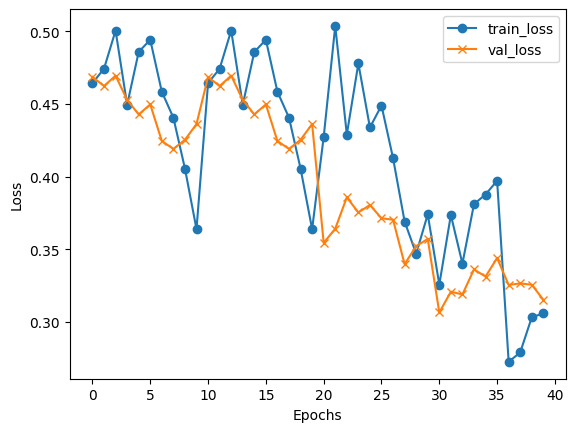

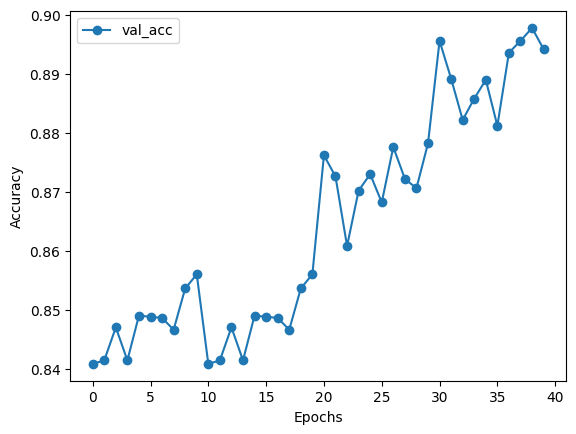

In [50]:
import torch
from matplotlib import pyplot as plt
import numpy as np

plt.figure(1)
plt.xlabel("Epochs")
plt.ylabel("Loss")
test_loss = output[1]
val_loss = [x["val_loss"].cpu().numpy() for x in output[0]]
val_acc = [x["val_acc"] for x in output[0]]

for output in [output1, output3, output4]:
    val_loss.extend([x["val_loss"].cpu().numpy() for x in output[0]])
    val_acc.extend([x["val_acc"] for x in output[0]])
    test_loss.extend(output[1])

plt.plot(np.array(torch.tensor(test_loss, device=torch.device("cpu"))), "-o", label="train_loss")
plt.plot(np.array(val_loss), "-x", label="val_loss")
plt.legend()

plt.figure(2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.plot(np.array(val_acc), "-o", label="val_acc")
plt.legend()

plt.show()